# 🧼 Step 1: Data Cleaning and Session Filtering

In [15]:
pip install openpyxl

In [17]:
# import os
import csv

# Define expected physiological data files collected from wearable biosensors
expected_files = {
    'ACC.csv',   # Accelerometer data – records 3-axis movement (physical activity)
    'BVP.csv',   # Blood Volume Pulse – used to derive heart rate and heart rate variability
    'EDA.csv',   # Electrodermal Activity – measures skin conductance, related to stress/arousal
    'HR.csv',    # Heart Rate – beats per minute, often derived from BVP or IBI
    'IBI.csv',   # Interbeat Interval – time between heartbeats in milliseconds
    'TEMP.csv'   # Temperature – measures peripheral body temperature
    # 'TAGS.csv' # Event markers – optional, typically used to log events manually (excluded)
}

# Root folder containing all participant directories
root_folder = r"C:\Users\HP\OneDrive\Desktop\DRYAD_STRESS_DATA"  # TODO: replace with your dataset path

# Initialize report list to store missing file info
missing_report = []

# Traverse participant folders and nested session folders
for participant in os.listdir(root_folder):
    participant_path = os.path.join(root_folder, participant)
    if os.path.isdir(participant_path):
        for session in os.listdir(participant_path):
            session_path = os.path.join(participant_path, session)
            if os.path.isdir(session_path):
                present_files = set(os.listdir(session_path))
                missing = expected_files - present_files
                if missing:
                    # Append tuple: (participant folder, session folder, missing files)
                    missing_report.append((participant, session, ', '.join(sorted(missing))))

# Export the missing files report as a CSV
output_file = 'missing_files_report.csv'
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Participant', 'Session', 'Missing Files'])
    writer.writerows(missing_report)

print(f"✅ Report saved as '{output_file}'")


✅ Report saved as 'missing_files_report.csv'


In [19]:
import os
import shutil

# Define required biosensor files
expected_files = {
    'ACC.csv',   # Accelerometer data
    'BVP.csv',   # Blood Volume Pulse
    'EDA.csv',   # Electrodermal Activity
    'HR.csv',    # Heart Rate
    'IBI.csv',   # Interbeat Interval
    'TEMP.csv'   # Temperature
}

# Define root dataset and destination path
root_folder = r'C:\Users\HP\OneDrive\Desktop\DRYAD_STRESS_DATA'  # 👈 Update this to yours
output_root = os.path.join(root_folder, 'clean_sessions')

# Create the output directory if it doesn't exist
os.makedirs(output_root, exist_ok=True)

# Begin filtering
complete_sessions = 0
total_sessions = 0

for participant in os.listdir(root_folder):
    participant_path = os.path.join(root_folder, participant)
    if not os.path.isdir(participant_path):
        continue

    for session in os.listdir(participant_path):
        session_path = os.path.join(participant_path, session)
        if not os.path.isdir(session_path):
            continue

        total_sessions += 1
        present_files = set(os.listdir(session_path))

        if expected_files.issubset(present_files):
            # This is a complete session — copy it
            dest_participant_folder = os.path.join(output_root, participant)
            dest_session_folder = os.path.join(dest_participant_folder, session)
            os.makedirs(dest_session_folder, exist_ok=True)

            for file in expected_files:
                src_file = os.path.join(session_path, file)
                dst_file = os.path.join(dest_session_folder, file)
                shutil.copy2(src_file, dst_file)

            complete_sessions += 1

print(f"✅ Done! {complete_sessions} complete sessions copied to: {output_root}")
print(f"📊 Out of {total_sessions} sessions checked.")


✅ Done! 609 complete sessions copied to: C:\Users\HP\OneDrive\Desktop\DRYAD_STRESS_DATA\clean_sessions
📊 Out of 624 sessions checked.


# 🏷️ Step 2: Lifecycle Phase Tagging

In [23]:
import os
import pandas as pd
from datetime import datetime

def read_initial_time(file_path):
    """Read first line of a sensor file to get UNIX start time."""
    with open(file_path, 'r') as f:
        first_line = f.readline().strip()
        try:
            return datetime.utcfromtimestamp(int(float(first_line)))
        except:
            return None

def tag_phase(days_since_start):
    """Tag lifecycle phase based on number of days since baseline session."""
    if days_since_start <= 14:
        return 'Initial_Phase'
    elif days_since_start <= 90:
        return 'Adjustment_Phase'
    else:
        return 'Prolonged_Strain_Phase'

# Set your data path
data_root = r'C:\Users\HP\OneDrive\Desktop\DRYAD_STRESS_DATA\clean_sessions'
output_path = r'C:\Users\HP\OneDrive\Desktop\DRYAD_STRESS_DATA\session_lifecycle_tags.csv'

tagged_sessions = []

# Loop through each participant
for participant in os.listdir(data_root):
    participant_path = os.path.join(data_root, participant)
    if not os.path.isdir(participant_path):
        continue

    session_times = []

    # Extract start time for each session
    for session in os.listdir(participant_path):
        session_path = os.path.join(participant_path, session)
        eda_path = os.path.join(session_path, 'EDA.csv')  # could also use HR.csv or TEMP.csv
        
        if os.path.isfile(eda_path):
            start_time = read_initial_time(eda_path)
            if start_time:
                session_times.append((session, start_time))

    # Sort and compute lifecycle tags
    session_times.sort(key=lambda x: x[1])
    if session_times:
        baseline = session_times[0][1]
        for session_id, start_time in session_times:
            days_elapsed = (start_time - baseline).days
            phase = tag_phase(days_elapsed)
            tagged_sessions.append({
                'participant_id': participant,
                'session_id': session_id,
                'session_start_time': start_time,
                'days_since_baseline': days_elapsed,
                'employment_phase': phase
            })

# Save to CSV
tagged_df = pd.DataFrame(tagged_sessions)
tagged_df.to_csv(output_path, index=False)

print(f"✅ Lifecycle mapping exported to:\n{output_path}")


✅ Lifecycle mapping exported to:
C:\Users\HP\OneDrive\Desktop\DRYAD_STRESS_DATA\session_lifecycle_tags.csv


# 📈 Step 3: Stress Feature Extraction

In [24]:
import os
import pandas as pd
import numpy as np

# Define the folder containing clean sessions
data_root = r'C:\Users\HP\OneDrive\Desktop\DRYAD_STRESS_DATA\clean_sessions'

# List to store extracted features
features_list = []

# Utility functions
def compute_eda_features(df):
    eda_values = df.iloc[2:, 0].astype(float)
    return {
        'EDA_mean': eda_values.mean(),
        'EDA_std': eda_values.std(),
        'EDA_max': eda_values.max(),
        'EDA_min': eda_values.min(),
        'EDA_range': eda_values.max() - eda_values.min(),
        'EDA_peaks': ((eda_values.diff() > 0) & (eda_values.diff().shift(-1) < 0)).sum()
    }

def compute_hr_features(df):
    hr_values = df.iloc[2:, 0].astype(float)
    return {
        'HR_mean': hr_values.mean(),
        'HR_std': hr_values.std(),
        'HR_max': hr_values.max(),
        'HR_min': hr_values.min(),
    }

def compute_ibi_features(df):
    # Check if second column exists
    if df.shape[1] < 2:
        return {
            'IBI_mean': np.nan,
            'IBI_std': np.nan,
            'HRV_rmssd': np.nan
        }

    try:
        ibi_values = df.iloc[1:, 1].astype(float)
        ibi_diffs = np.diff(ibi_values)
        rmssd = np.sqrt(np.mean(ibi_diffs**2)) if len(ibi_diffs) > 1 else np.nan
        return {
            'IBI_mean': ibi_values.mean(),
            'IBI_std': ibi_values.std(),
            'HRV_rmssd': rmssd
        }
    except Exception as e:
        print(f"⚠️ Error computing IBI features: {e}")
        return {
            'IBI_mean': np.nan,
            'IBI_std': np.nan,
            'HRV_rmssd': np.nan
        }

# Traverse participant folders and session folders
for participant in os.listdir(data_root):
    participant_path = os.path.join(data_root, participant)
    if not os.path.isdir(participant_path):
        continue

    for session in os.listdir(participant_path):
        session_path = os.path.join(participant_path, session)
        if not os.path.isdir(session_path):
            continue

        feature_row = {
            'participant_id': participant,
            'session_id': session
        }

        # Process EDA
        eda_path = os.path.join(session_path, 'EDA.csv')
        if os.path.isfile(eda_path):
            try:
                eda_df = pd.read_csv(eda_path, header=None)
                if not eda_df.empty:
                    feature_row.update(compute_eda_features(eda_df))
            except pd.errors.EmptyDataError:
                print(f"⚠️ EDA.csv is empty in {participant}/{session}")

        # Process HR
        hr_path = os.path.join(session_path, 'HR.csv')
        if os.path.isfile(hr_path):
            try:
                hr_df = pd.read_csv(hr_path, header=None)
                if not hr_df.empty:
                    feature_row.update(compute_hr_features(hr_df))
            except pd.errors.EmptyDataError:
                print(f"⚠️ HR.csv is empty in {participant}/{session}")

        # Process IBI
        ibi_path = os.path.join(session_path, 'IBI.csv')
        if os.path.isfile(ibi_path):
            try:
                ibi_df = pd.read_csv(ibi_path, header=None)
                if not ibi_df.empty:
                    feature_row.update(compute_ibi_features(ibi_df))
            except pd.errors.EmptyDataError:
                print(f"⚠️ IBI.csv is empty in {participant}/{session}")

        features_list.append(feature_row)

# Convert to DataFrame and save
features_df = pd.DataFrame(features_list)
features_df.to_csv('stress_features.csv', index=False)
print("✅ Stress features exported as 'stress_features.csv'")


⚠️ IBI.csv is empty in 15/15_1595862148
⚠️ IBI.csv is empty in 15/15_1595866250
⚠️ IBI.csv is empty in 15/15_1595869772
⚠️ IBI.csv is empty in 15/15_1595970459
⚠️ IBI.csv is empty in 15/15_1596219716
⚠️ IBI.csv is empty in 15/15_1596634348
⚠️ IBI.csv is empty in 5C/5C_1586886626
⚠️ IBI.csv is empty in 5C/5C_1587338580
⚠️ IBI.csv is empty in 5C/5C_1587593082
⚠️ IBI.csv is empty in 5C/5C_1587649438
⚠️ IBI.csv is empty in 5C/5C_1589199819
⚠️ IBI.csv is empty in 5C/5C_1592925628
⚠️ IBI.csv is empty in 5C/5C_1592925705
⚠️ IBI.csv is empty in 5C/5C_1593018203
⚠️ IBI.csv is empty in 6B/6B_1587661095
⚠️ IBI.csv is empty in 6B/6B_1587662477
⚠️ IBI.csv is empty in 6B/6B_1593083317
⚠️ IBI.csv is empty in 6B/6B_1593086670
⚠️ IBI.csv is empty in 6B/6B_1593535767
⚠️ IBI.csv is empty in 6D/6D_1594751512
⚠️ IBI.csv is empty in 6D/6D_1595252734
⚠️ IBI.csv is empty in 7A/7A_1587212302
⚠️ IBI.csv is empty in 7A/7A_1587734399
⚠️ IBI.csv is empty in 7A/7A_1592752730
⚠️ IBI.csv is empty in 7A/7A_1592925663


In [42]:
import pandas as pd

# Load the two CSV files
features_df = pd.read_csv('stress_features.csv')
lifecycle_df = pd.read_csv('session_lifecycle_tags.csv')

# Rename columns to match for merge
lifecycle_df = lifecycle_df.rename(columns={
    'participant': 'participant_id',
    'session': 'session_id'
})

# Merge on participant and session IDs
merged_df = pd.merge(features_df, lifecycle_df, on=['participant_id', 'session_id'], how='inner')

# Save merged dataset
output_path = r'C:\Users\HP\OneDrive\Desktop\DRYAD_STRESS_DATA\merged_stress_lifecycle.csv'
merged_df.to_csv(output_path, index=False)
print(f"✅ Merged stress lifecycle data saved at:\n{output_path}")


✅ Merged stress lifecycle data saved at:
C:\Users\HP\OneDrive\Desktop\DRYAD_STRESS_DATA\merged_stress_lifecycle.csv


# 📊 Step 4: Data Visualization

In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the merged dataset
df = pd.read_csv('merged_stress_lifecycle.csv')

# Optional: Set style for cleaner visuals
sns.set(style='whitegrid', palette='muted')


# 📊 Distribution Plots for EDA_mean and HRV (RMSSD)

In [73]:
merged = pd.merge(features_df, phases_df, on=['participant_id', 'session_id'])

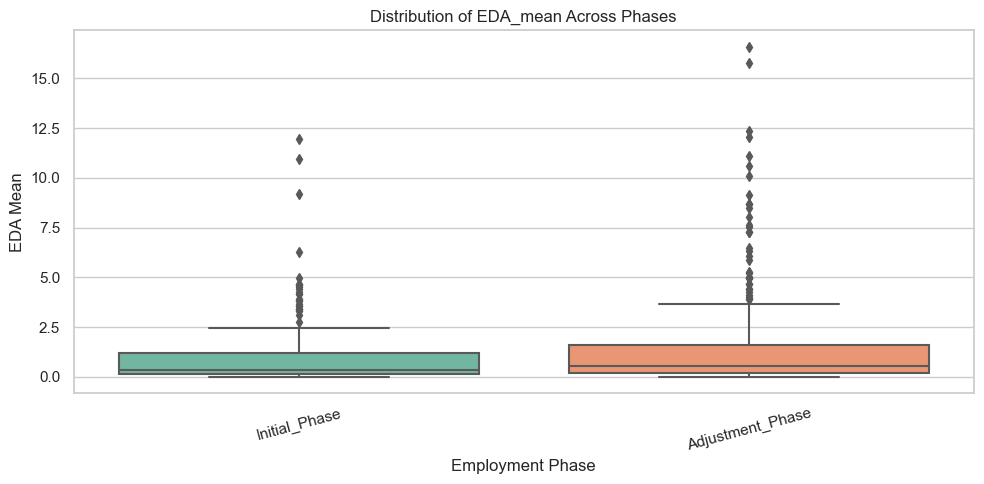

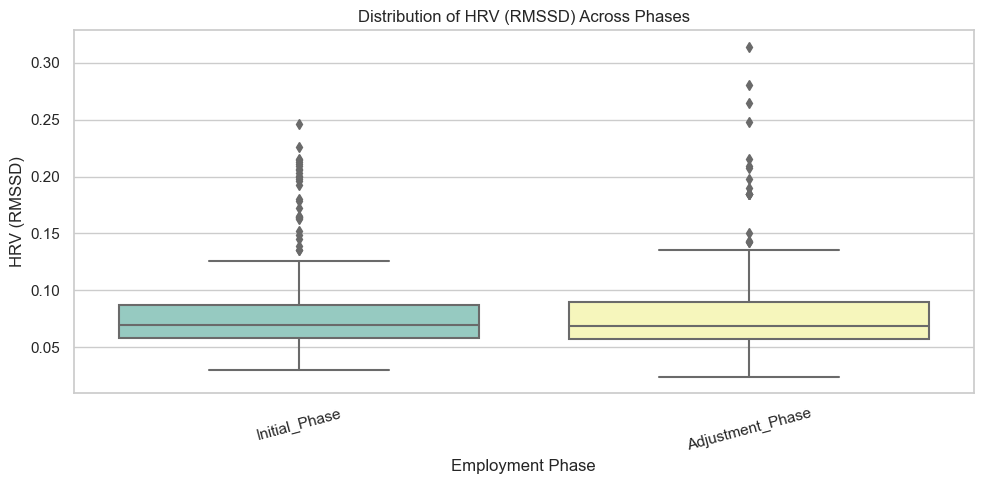

In [76]:
# Plot 1: EDA_mean by Employment Phase
plt.figure(figsize=(10, 5))
sns.boxplot(data=merged, x='employment_phase', y='EDA_mean', palette='Set2')
plt.title("Distribution of EDA_mean Across Phases")
plt.ylabel("EDA Mean")
plt.xlabel("Employment Phase")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Plot 2: HRV (RMSSD) by Employment Phase
plt.figure(figsize=(10, 5))
sns.boxplot(data=merged, x='employment_phase', y='HRV_rmssd', palette='Set3')
plt.title("Distribution of HRV (RMSSD) Across Phases")
plt.ylabel("HRV (RMSSD)")
plt.xlabel("Employment Phase")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()